failed attempt to train separate models for auc and rce

# start

In [49]:
PRFX='0318_4'
# http://localhost:8081/notebooks/git/recsys20/working/prep0318_1.ipynb
PRFX_PRP = 'prep0318_1' 
langs = ['3A85BCEC571C3F5AB1069E4924189177','515E873C86EE1577E75FA2387B7FA59E',]
trntmstmp=1584412344
valtmstmp=1584405047
import datetime
[datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)]

['2020-03-17 02:32:24', '2020-03-17 00:30:47']

# setup

In [50]:
from pathlib import Path
import dask
print('dask.__version__', dask.__version__)
import xgboost
import dask_xgboost
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from dask.distributed import Client
import pickle
import lightgbm as lgb

import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_prp=f'{HOME}/output/{PRFX_PRP}'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwing_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_follower_cnt',
'u2_following_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]

cols_val = cols[:-4]

tgts     = ['Retweet','Reply','Like','RTwCmnt',]
cols_tgt = ['retwt',  'reply','like','retwt_cmmnt',]


dask.__version__ 2.12.0


# prepare data

In [51]:
df = dd.concat([dd.read_csv(f'{p_prp}/dftrn_{lang}_{trntmstmp}__{PRFX_PRP}.tsv',sep='\x01') for lang in langs])

In [52]:
%%time
# https://stackoverflow.com/questions/40376425/dask-dataframe-equivalent-of-pandas-dataframe-sort-values
lendf = df.shape[0].compute()
valsz = int(lendf*0.15)
trnsz = lendf-valsz
lendf, trnsz, valsz

CPU times: user 100 ms, sys: 11.2 ms, total: 111 ms
Wall time: 708 ms


(45628, 38784, 6844)

In [53]:
%%time
dftr=df.nsmallest(trnsz,'tm')
dfvl=df.nlargest(valsz,'tm')

assert dfvl.tm.min().compute() >= dftr.tm.max().compute()

CPU times: user 221 ms, sys: 31.8 ms, total: 252 ms
Wall time: 1.6 s


In [54]:
dftr.columns

Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_follower_cnt', 'u2_following_cnt',
       'u2_vrfed', 'u2_create_tm', 'u1_fllw_u2', 'reply_tm', 'retwt_tm',
       'retwt_cmmnt_tm', 'like_tm', 'len_toks', 'has_media_Photo',
       'has_media_Video', 'has_media_GIF', 'num_hshtgs', 'num_links',
       'num_domns', 'twttyp_TopLevel', 'twttyp_Retweet', 'twttyp_Quote',
       'tmdlta_u2u1', 'tmdlta_twtu1', 'tmdlta_twtu2', 'reply', 'retwt',
       'retwt_cmmnt', 'like'],
      dtype='object')

In [55]:
cols_feat=[
       'tm', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2_follower_cnt', 'u2_following_cnt',
       'u2_vrfed', 'u2_create_tm', 'u1_fllw_u2', 'len_toks', 'has_media_Photo',
       'has_media_Video', 'has_media_GIF', 'num_hshtgs', 'num_links',
       'num_domns', 'twttyp_TopLevel', 'twttyp_Retweet', 'twttyp_Quote',
       'tmdlta_u2u1', 'tmdlta_twtu1', 'tmdlta_twtu2',
]

In [56]:
%%time
X, ys = (df[cols].to_dask_array(lengths=True) for cols in (cols_feat,cols_tgt))

CPU times: user 200 ms, sys: 16.8 ms, total: 217 ms
Wall time: 1.3 s


In [57]:
%%time
Xtrn, Xval, ystrn, ysval = train_test_split(X, ys, test_size=0.15, random_state=SEED)

CPU times: user 21.7 ms, sys: 0 ns, total: 21.7 ms
Wall time: 17.7 ms


# train

In [58]:
client = Client()

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [61]:
# https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
# When you observe high training accuracy, but low test accuracy, it is likely 
# that you encountered overfitting problem.
# There are in general two ways that you can control overfitting in XGBoost:
# The first way is to directly control model complexity.
# This includes max_depth, min_child_weight and gamma.
# The second way is to add randomness to make training robust to noise.
# This includes subsample and colsample_bytree.
# You can also reduce stepsize eta. Remember to increase num_round when you do so.

# https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
# If you care only about the overall performance metric (AUC) of your prediction
# Balance the positive and negative weights via scale_pos_weight
# https://xgboost.readthedocs.io/en/latest/parameter.html
# Use AUC for evaluation
# Control the balance of positive and negative weights, useful for unbalanced classes. 
# A typical value to consider: sum(negative instances) / sum(positive instances). 
# See Parameters Tuning for more discussion. Also, see Higgs Kaggle competition demo 
# for examples: R, py1, py2, py3.

# https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
# If you care about predicting the right probability
# In such a case, you cannot re-balance the dataset
# Set parameter max_delta_step to a finite number (say 1) to help convergence


mtrc2tgt2params ={ 
    'auc': {
        'Retweet': {
            'objective': 'binary:logistic',
            'max_depth':5,
            'min_child_weight':2,
            'gamma':1,
        }, 
        'Reply': {
            'objective': 'binary:logistic',
            'max_depth':5,
            'min_child_weight':2,
            'gamma':1,
        }, 
        'Like': {
            'objective': 'binary:logistic',
            'max_depth':5,
            'min_child_weight':2,
            'gamma':1,
        }, 
        'RTwCmnt': {
            'objective': 'binary:logistic',
            'max_depth':5,
            'min_child_weight':2,
            'gamma':1,
        }, 
    },
    'rce': {
        'Retweet': {
            'objective': 'binary:logistic',
            'max_depth':5,
            'min_child_weight':2,
            'gamma':1,
            'max_delta_step':1,
        }, 
        'Reply': {
            'objective': 'binary:logistic',
            'max_depth':5,
            'min_child_weight':2,
            'gamma':1,
            'max_delta_step':1,
        }, 
        'Like': {
            'objective': 'binary:logistic',
            'max_depth':5,
            'min_child_weight':2,
            'gamma':1,
            'max_delta_step':1,
        }, 
        'RTwCmnt': {
            'objective': 'binary:logistic',
            'max_depth':5,
            'min_child_weight':2,
            'gamma':1,
            'max_delta_step':1,
        }, 
    },
}

In [86]:
foo=np.array([1,0,1])
avg=np.mean(foo)
ratio=(1-avg)/avg
ratio, sum(foo==0)/sum(foo==1)

(0.5000000000000001, 0.5)

In [92]:
%%time
ymeans=ystrn.mean(0)
ratios=dask.compute([(1-o)/o for o in ymeans])[0]
ratios

CPU times: user 147 ms, sys: 26.3 ms, total: 173 ms
Wall time: 666 ms


[11.961898395721922, 51.26684636118598, 0.8756105818058714, 216.87640449438203]

In [94]:
for i,tgt in enumerate(tgts):
    mtrc2tgt2params['auc'][tgt]['scale_pos_weight']=ratios[i]

mtrc2tgt2params

{'auc': {'Retweet': {'objective': 'binary:logistic',
   'max_depth': 5,
   'min_child_weight': 2,
   'gamma': 1,
   'scale_pos_weight': 11.961898395721922},
  'Reply': {'objective': 'binary:logistic',
   'max_depth': 5,
   'min_child_weight': 2,
   'gamma': 1,
   'scale_pos_weight': 51.26684636118598},
  'Like': {'objective': 'binary:logistic',
   'max_depth': 5,
   'min_child_weight': 2,
   'gamma': 1,
   'scale_pos_weight': 0.8756105818058714},
  'RTwCmnt': {'objective': 'binary:logistic',
   'max_depth': 5,
   'min_child_weight': 2,
   'gamma': 1,
   'scale_pos_weight': 216.87640449438203}},
 'rce': {'Retweet': {'objective': 'binary:logistic',
   'max_depth': 5,
   'min_child_weight': 2,
   'gamma': 1,
   'max_delta_step': 1},
  'Reply': {'objective': 'binary:logistic',
   'max_depth': 5,
   'min_child_weight': 2,
   'gamma': 1,
   'max_delta_step': 1},
  'Like': {'objective': 'binary:logistic',
   'max_depth': 5,
   'min_child_weight': 2,
   'gamma': 1,
   'max_delta_step': 1},
  '

In [95]:
mtrc2tgt2bst={}
mtrc2tgt2col2fscr={}

for mtrc, tgt2params in mtrc2tgt2params.items():
    mtrc2tgt2bst[mtrc]={}
    mtrc2tgt2col2fscr[mtrc]={}
    for i,tgt in enumerate(tgts):
        params = tgt2params[tgt]
        print(dtnow(), mtrc, tgt)
        bst = dask_xgboost.train(client, params,
                                 Xtrn, ystrn[:,i])
        mtrc2tgt2bst[mtrc][tgt]=bst
    
        fi2col=dict(zip(bst.feature_names, cols_feat))
        col2fi=dict(zip(cols_feat, bst.feature_names))
        fi2fscr=bst.get_fscore()
        col2fscr={col:fi2fscr.get(fi,0) for col,fi in col2fi.items()}
        mtrc2tgt2col2fscr[mtrc][tgt]=col2fscr

pickle.dump(mtrc2tgt2bst, open(f"{p_out}/mtrc2tgt2bst.p", "wb"))

2020-03-18 19:46:59 auc
2020-03-18 19:46:59 Retweet
2020-03-18 19:47:03 Reply
2020-03-18 19:47:06 Like
2020-03-18 19:47:10 RTwCmnt
2020-03-18 19:47:13 rce
2020-03-18 19:47:13 Retweet
2020-03-18 19:47:17 Reply
2020-03-18 19:47:20 Like
2020-03-18 19:47:24 RTwCmnt


In [96]:
mtrc2tgt2bst=pickle.load(open(f"{p_out}/mtrc2tgt2bst.p", "rb"))

auc Retweet


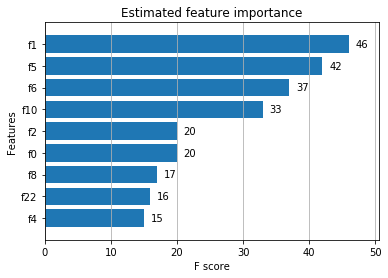

,0,1
1,u1_fllwer_cnt,46
5,u2_follower_cnt,42
6,u2_following_cnt,37
10,len_toks,33
0,tm,20
2,u1_fllwing_cnt,20
8,u2_create_tm,17
22,tmdlta_twtu2,16
4,u1_create_tm,15
14,num_hshtgs,15


auc Reply


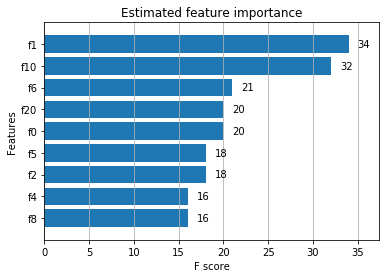

,0,1
1,u1_fllwer_cnt,34
10,len_toks,32
6,u2_following_cnt,21
0,tm,20
20,tmdlta_u2u1,20
2,u1_fllwing_cnt,18
5,u2_follower_cnt,18
4,u1_create_tm,16
8,u2_create_tm,16
18,twttyp_Retweet,12


auc Like


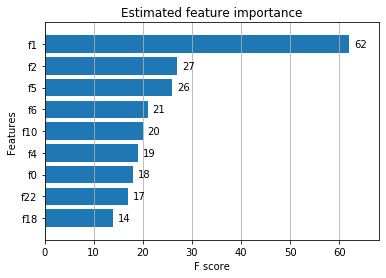

,0,1
1,u1_fllwer_cnt,62
2,u1_fllwing_cnt,27
5,u2_follower_cnt,26
6,u2_following_cnt,21
10,len_toks,20
4,u1_create_tm,19
0,tm,18
22,tmdlta_twtu2,17
18,twttyp_Retweet,14
15,num_links,13


auc RTwCmnt


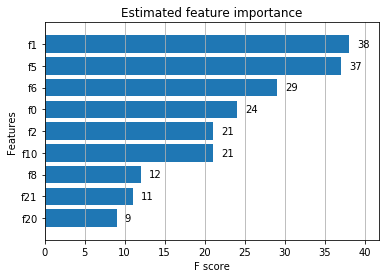

,0,1
1,u1_fllwer_cnt,38
5,u2_follower_cnt,37
6,u2_following_cnt,29
0,tm,24
10,len_toks,21
2,u1_fllwing_cnt,21
8,u2_create_tm,12
21,tmdlta_twtu1,11
20,tmdlta_u2u1,9
22,tmdlta_twtu2,8


rce Retweet


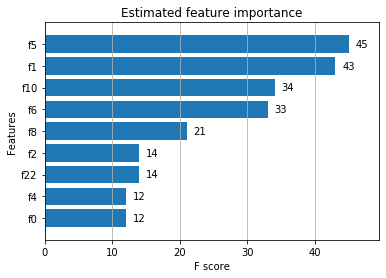

,0,1
5,u2_follower_cnt,45
1,u1_fllwer_cnt,43
10,len_toks,34
6,u2_following_cnt,33
8,u2_create_tm,21
22,tmdlta_twtu2,14
2,u1_fllwing_cnt,14
0,tm,12
4,u1_create_tm,12
9,u1_fllw_u2,11


rce Reply


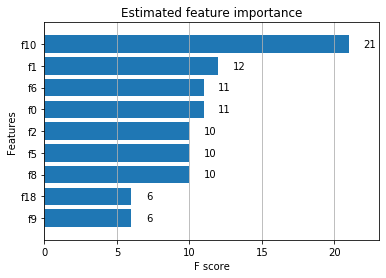

,0,1
10,len_toks,21
1,u1_fllwer_cnt,12
0,tm,11
6,u2_following_cnt,11
2,u1_fllwing_cnt,10
5,u2_follower_cnt,10
8,u2_create_tm,10
18,twttyp_Retweet,6
9,u1_fllw_u2,6
21,tmdlta_twtu1,5


rce Like


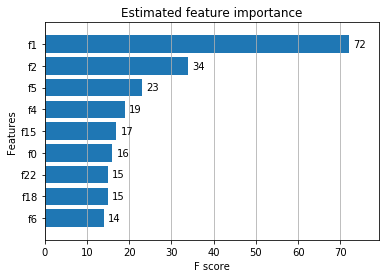

,0,1
1,u1_fllwer_cnt,72
2,u1_fllwing_cnt,34
5,u2_follower_cnt,23
4,u1_create_tm,19
15,num_links,17
0,tm,16
18,twttyp_Retweet,15
22,tmdlta_twtu2,15
6,u2_following_cnt,14
10,len_toks,13


rce RTwCmnt


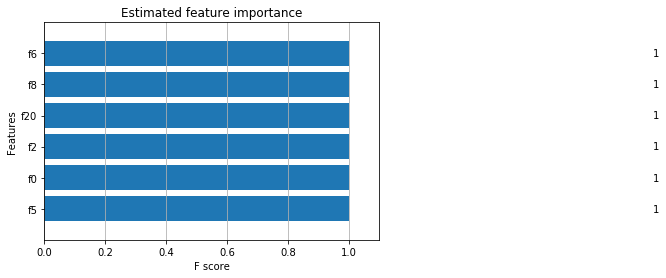

,0,1
0,tm,1
2,u1_fllwing_cnt,1
20,tmdlta_u2u1,1
5,u2_follower_cnt,1
6,u2_following_cnt,1
8,u2_create_tm,1
14,num_hshtgs,0
21,tmdlta_twtu1,0
19,twttyp_Quote,0
18,twttyp_Retweet,0


In [97]:
def show_feat_importance(bst):
    ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title('Estimated feature importance')
    plt.show()
for mtrc, tgt2bst in mtrc2tgt2bst.items():
    for tgt,bst in tgt2bst.items():
        print(mtrc, tgt)
        show_feat_importance(mtrc2tgt2bst[mtrc][tgt])
        col2fscr=mtrc2tgt2col2fscr[mtrc][tgt]
        display(pd.DataFrame(col2fscr.items()).sort_values(1, ascending=False))

# validate

In [104]:
mtrc2tgt2ytrn={}
mtrc2tgt2yval={}
mtrc2tgt2prdtrn={}
mtrc2tgt2prdval={}
for mtrc, tgt2bst in mtrc2tgt2bst.items():
    mtrc2tgt2ytrn[mtrc]  ={}
    mtrc2tgt2yval[mtrc]  ={}
    mtrc2tgt2prdtrn[mtrc]={}
    mtrc2tgt2prdval[mtrc]={}
    for i,tgt in enumerate(tgts):
        print(dtnow(), mtrc, tgt)
        prdtrn = dask_xgboost.predict(client, tgt2bst[tgt], Xtrn).persist()
        prdval = dask_xgboost.predict(client, tgt2bst[tgt], Xval).persist()
        ytrn, prdtrn = dask.compute(ystrn[:,i], prdtrn)
        yval, prdval = dask.compute(ysval[:,i], prdval)
        mtrc2tgt2ytrn[mtrc][tgt],mtrc2tgt2yval[mtrc][tgt]=ytrn,yval
        mtrc2tgt2prdtrn[mtrc][tgt],mtrc2tgt2prdval[mtrc][tgt]=prdtrn,prdval

2020-03-18 19:50:59 Retweet
2020-03-18 19:51:00 Reply
2020-03-18 19:51:02 Like
2020-03-18 19:51:04 RTwCmnt
2020-03-18 19:51:06 Retweet
2020-03-18 19:51:07 Reply
2020-03-18 19:51:09 Like
2020-03-18 19:51:11 RTwCmnt


In [99]:
def show_roc_auc(prd,y):
    fpr, tpr, _ = roc_curve(y,prd)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(fpr, tpr, lw=3,
            label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set(
        xlim=(0, 1),
        ylim=(0, 1),
        title="ROC Curve",
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
    )
    ax.legend();
    plt.show()

In [105]:
mtrc2tgt2auc_trn={}
mtrc2tgt2rce_trn={}
mtrc2tgt2auc_val={}
mtrc2tgt2rce_val={}
for mtrc in mtrc2tgt2bst:
    mtrc2tgt2auc_trn[mtrc]={}
    mtrc2tgt2rce_trn[mtrc]={}
    mtrc2tgt2auc_val[mtrc]={}
    mtrc2tgt2rce_val[mtrc]={}
    for i,tgt in enumerate(tgts):
        print(mtrc, tgt)
        ytrn,yval = tgt2ytrn[tgt],tgt2yval[tgt]
        prdtrn,prdval = tgt2prdtrn[tgt],tgt2prdval[tgt]
        scr_rocauc_trn = roc_auc_score(ytrn, prdtrn)
        scr_rocauc_val = roc_auc_score(yval, prdval)
        scr_auc_trn=compute_prauc(prdtrn, ytrn)
        scr_rce_trn=compute_rce(prdtrn, ytrn)
        scr_auc_val=compute_prauc(prdval, yval)
        scr_rce_val=compute_rce(prdval, yval)
        mtrc2tgt2auc_trn[mtrc][tgt]=scr_auc_trn
        mtrc2tgt2rce_trn[mtrc][tgt]=scr_rce_trn
        mtrc2tgt2auc_val[mtrc][tgt]=scr_auc_val
        mtrc2tgt2rce_val[mtrc][tgt]=scr_rce_val
        print('train rocauc:', f'{scr_rocauc_trn:.4f}', 'valid auc:', f'{scr_rocauc_val:.4f}', )
        print('train prauc:', f'{scr_auc_trn:.4f}', 'valid auc:', f'{scr_auc_val:.4f}', )
        print('train rce:', f'{scr_rce_trn:.4f}', 'valid rce:', f'{scr_rce_val:.4f}', )

auc Retweet
train rocauc: 0.7930 valid auc: 0.7654
train prauc: 0.2964 valid auc: 0.2324
train rce: 11.9327 valid rce: 9.9292
auc Reply
train rocauc: 0.7251 valid auc: 0.6879
train prauc: 0.1089 valid auc: 0.0399
train rce: -12.7088 valid rce: -17.6139
auc Like
train rocauc: 0.8141 valid auc: 0.7974
train prauc: 0.8183 valid auc: 0.8018
train rce: 22.1696 valid rce: 20.2417
auc RTwCmnt
train rocauc: 0.6305 valid auc: 0.5904
train prauc: 0.0303 valid auc: 0.0054
train rce: -113.5276 valid rce: -90.6793
rce Retweet
train rocauc: 0.7930 valid auc: 0.7654
train prauc: 0.2964 valid auc: 0.2324
train rce: 11.9327 valid rce: 9.9292
rce Reply
train rocauc: 0.7251 valid auc: 0.6879
train prauc: 0.1089 valid auc: 0.0399
train rce: -12.7088 valid rce: -17.6139
rce Like
train rocauc: 0.8141 valid auc: 0.7974
train prauc: 0.8183 valid auc: 0.8018
train rce: 22.1696 valid rce: 20.2417
rce RTwCmnt
train rocauc: 0.6305 valid auc: 0.5904
train prauc: 0.0303 valid auc: 0.0054
train rce: -113.5276 valid 